IDs:
* 302919402
*204030720

# Introduction

In our setting users make a binary decision of whether or not to consume an item. Each item is represented by a vector $x\in\mathbb{R}^n$, and the outcome is represented using binary variable $y\in\left\{-1,1\right\}$, such that $y=1$ when the item was consumed. 

For the implementation of behavioral bias models, we define the following abstract class:

In [ ]:
import abc

class UserModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate the user's valuation v(x) for each item x
    '''
    raise NotImplementedError()
  
  def predict(self, X, *args):
    '''
    Given items X, calculate the user's preference (-1/1) for each item x
    '''
    raise NotImplementedError()


class PopulationModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate each user's valuation v(x) for each item x
    '''
    raise NotImplementedError()
  
  def predict(self, X, *args):
    '''
    Given items X, calculate each user's preference y for each item x
    '''
    raise NotImplementedError()


## **A simple example**

**Create a user model**

In [ ]:
import numpy as np

class NoiseUserModel(UserModel):
  """
  v(x) = u*x + noise
  for a randomly generated u vector
  """

  def __init__(self, num_features):
    self.num_features = num_features
    self.utility_vec = np.random.randn(num_features)

  def __call__(self, X, noise_std):
    noise = noise_std * np.random.randn(X.shape[0])
    return X @ self.utility_vec + noise
  
  def predict(self, X, noise_std):
    return np.sign(self(X, noise_std))

**Create a population model**

In [ ]:
class NoisePopulationModel(PopulationModel):
  """
  aggregates a population of users into a population model 
  """

  def __init__(self, num_users, num_features):
    self.user_models = [NoiseUserModel(num_features) for i in range(num_users)]

  def __call__(self, X, noise_std):
    """
    returns a matrix of size (number of items X number of uesrs)
    """
    return np.array([m(X, noise_std) for m in self.user_models]).T
  
  def predict(self, X, noise_std):
    return np.sign(self(X, noise_std))

**Load dataset**

In [ ]:
def generate_synth_data(num_features, num_items):
  """
  Generates a random dataset of items of size (num_items X num_features)
  """
  items = np.random.randn(num_items, num_features)
  return items

In [ ]:
num_features = 3
num_items = 100
num_users = 10

# Create a population model
population_model = NoisePopulationModel(num_users, num_features)

# Generate items
X = generate_synth_data(num_features, num_items)
args = {"noise_std":0.5}

# calculate users preferences according to the model
y = population_model.predict(X, **args)

**Create a training pipeline**

In [ ]:
from sklearn.model_selection import train_test_split

class TrainingPipeline():
  def __init__(self, training_model, metrics, test_size=0.33,
               seed=0):
    """
    training_model: a scikit training model
    metrics: a dictionary of metric functions (values) and their names (keys).
    each one takes (training_model, population_model, model_args, X) as arguments.
    """
    self.training_model = training_model
    self.metrics = metrics
    self.test_size = test_size
    self.seed = seed

  # Splits the data into train and test sets
  def split(self, X, y):
    return train_test_split(X, y, test_size=self.test_size, random_state=self.seed)

  # train the model on the train dataset
  def fit(self, X_train, y_train):
    self.training_model.fit(X_train, y_train)

  # activate each metric on the the test set
  def evaluate(self, population_model, model_args, X_test):
    if model_args is None:
      model_args = {}
    return {name : metric(self.training_model, population_model, model_args, X_test) for name, metric in
            metrics.items()}

  # Split, fit and evaluate
  def __call__(self, X, y, population_model, model_args=None):
    """
    Calls split, then trains the model and then evaluates it according to each metric 
    """
    X_train, X_test, y_train, y_test = self.split(X, y)
    self.fit(X_train, y_train)
    return self.evaluate(population_model, model_args, X_test)

**Create some evaluation metrics**

In [ ]:
from sklearn.metrics import accuracy_score

# calculates the accuracy of the training_model
def accuracy(training_model, population_model, model_args, X):
  true_valuations = population_model(X, **model_args)
  pred_valuations = training_model.predict(X)

  return accuracy_score(np.sign(true_valuations).flatten(),
                        np.sign(pred_valuations).flatten())

**Train!**

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Create linear regression object
training_model = LinearRegression()

# Create metrics list
metrics = {"accuracy" : accuracy}

# Create pipeline
t = TrainingPipeline(training_model, metrics)

# Train and evaluate
args = {"noise_std": 0.5}
results = t(X, y, population_model, args)
results

{'accuracy': 0.8939393939393939}

**Q3:**

In [ ]:
import numpy as np


def sigmoid(x):
  return 1 / (1 + np.exp(-x))


class SigmoidUserModel(UserModel):
  """
  v(x) = sigmoid(u*x) - 0.5
  for a randomly generated u vector
  """
  def __init__(self, num_features, valuation_bias: float = 0.5):
    self.num_features = num_features
    self.utility_vec = np.random.randn(num_features)
    self.valuation_bias = valuation_bias
  
  def __call__(self, X):
    return sigmoid(X @ self.utility_vec) - self.valuation_bias
  
  def predict(self, X):
    return np.sign(self(X))

In [ ]:
class SigmoidPopulationModel(PopulationModel):
  """
  aggregates a population of users into a population model 
  """
  def __init__(self, num_users, num_features):
    self.user_models = [SigmoidUserModel(num_features) for i in range(num_users)]

  def __call__(self, X):
    """
    returns a matrix of size (number of items X number of uesrs)
    """
    return np.array([m(X) for m in self.user_models]).T
  
  def predict(self, X):
    return np.sign(self(X))

**Q4:**

In [ ]:
num_features = 3
num_items = 1000
num_users = 100

# Create a population model
sig_population_model = SigmoidPopulationModel(num_users, num_features)

# Generate items
X = generate_synth_data(num_features, num_items)
args = {}

# calculate users preferences according to the model
sig_y = sig_population_model.predict(X, **args)

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Create linear regression object
lin_training_model = LinearRegression()

# Create metrics list
metrics = {"accuracy" : accuracy}

# Create pipeline
lin_t = TrainingPipeline(lin_training_model, metrics)

# Train and evaluate
args = {}
results = lin_t(X, sig_y, sig_population_model, args)
results

{'accuracy': 0.984030303030303}

**Q5:**

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Create linear regression object
log_training_model = MultiOutputClassifier(LogisticRegression())

# Create metrics list
metrics = {"accuracy" : accuracy}

# Create pipeline
log_t = TrainingPipeline(log_training_model, metrics)

# Train and evaluate
args = {}
results = log_t(X, sig_y, sig_population_model, args)
results

{'accuracy': 0.9922727272727273}

**Q6:**

  0%|          | 0/100 [00:00<?, ?it/s]

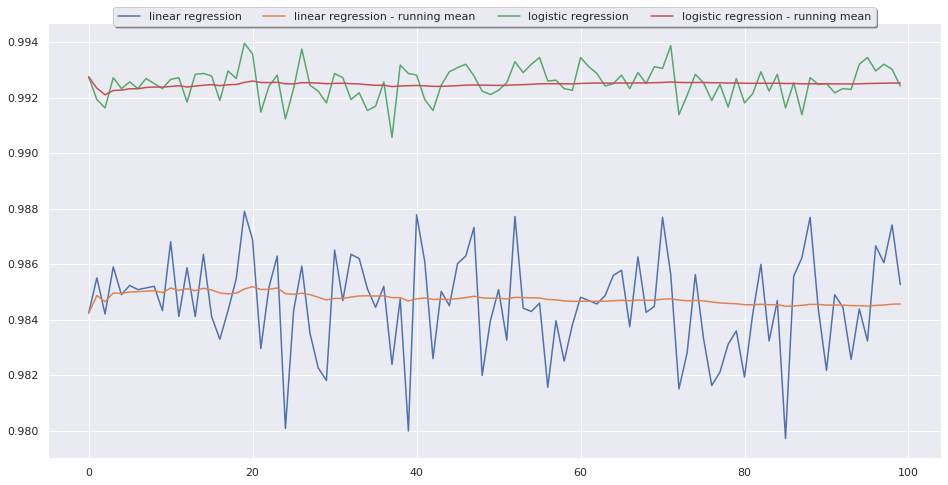

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from tqdm.notebook import tqdm


num_features = 3
num_items = 1000
num_users = 100

lin_results = []
log_results = []
lin_running_mean = []
log_running_mean = []

for i in tqdm(range(100)):
  # Create a population model
  sig_population_model = SigmoidPopulationModel(num_users, num_features)

  # Generate items
  X = generate_synth_data(num_features, num_items)
  args = {}

  # calculate users preferences according to the model
  sig_y = sig_population_model.predict(X, **args)

  # Train and evaluate
  args = {}
  lin_results.append(lin_t(X, sig_y, sig_population_model, {})['accuracy'])
  lin_running_mean.append(sum(lin_results) / len(lin_results))

  # Train and evaluate
  args = {}
  log_results.append(log_t(X, sig_y, sig_population_model, {})['accuracy'])
  log_running_mean.append(sum(log_results) / len(log_results))

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(lin_results, label='linear regression')
ax.plot(lin_running_mean, label='linear regression - running mean')
ax.plot(log_results, label='logistic regression')
ax.plot(log_running_mean, label='logistic regression - running mean')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True, shadow=True)
plt.show()

**Q7:**

We observe that the Logistic Regression model achieves approx. 1% better accuracy compared to the sign(Linear Regression) model. This happens because Logistic Regression is more suited for classification problems than Linear Regression (which is preferable for regression problems).

Linear regression uses OLS (ordinary least squares), while logistic regression uses MLE (maximum likelihood). This lead to the desired behavior for the classification task;
Linear regression quadratically penalizes outliers, and heavily affected y them, while Logistic regression penalizes large errors just by an asymptotically constant. 
e.g: applying Linear/Logistic regression for the categorical prediction {-1, 1} and assuming the model predicted 100: Linear regression will try to reduce the outcome towards 1, while Logistic regression would do it with far less strictness. 

The first population model (NoisePopulationModel) was (noisy) linear, hence the linear regression model could approximate it properly. However, the second population model (SigmoidPopulationModel) was not linear (sigmoid), thus the Linear regression predictive model performed worse than the Logistic regression predictive model.


**Q8:**

In [ ]:
def welfare(training_model, population_model, model_args, X):
  U = len(population_model.user_models)
  f = training_model.predict(X)
  sign = np.sign(f)
  I = (sign == 1).astype(np.int)
  v = population_model(X)
  welfare = np.sum(I*v)/U

  return welfare

print(welfare(lin_training_model, sig_population_model, {}, X))
print(welfare(log_training_model, sig_population_model, {}, X))

113.41368457427897
113.53669029863826


**Q9:**

In [ ]:
def MSE(training_model, population_model, model_args, X):
  U = len(population_model.user_models)
  M = X.shape[0]
  f = training_model.predict(X)
  v = population_model(X)
  MSE = np.sum((f-v)**2)*(1/(U*M))
  return MSE

print(MSE(lin_training_model, sig_population_model, {}, X))
print(MSE(log_training_model, sig_population_model, {}, X))

0.2995504484351881
0.6163860262849952
